In [1]:
import os
from typing import List
from langgraph.graph import StateGraph
from langchain_huggingface import HuggingFaceEndpoint
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain_community.llms import Llamafile
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain_community.llms import Ollama
from langchain_ollama.llms import OllamaLLM
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessageChunk, HumanMessage
from langchain_teddynote.graphs import visualize_graph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.messages import stream_graph, random_uuid
from typing import Literal
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_openai import ChatOpenAI
from langchain_chroma import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from chromadb.utils import embedding_functions
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.llms import HuggingFaceHub
from langchain_huggingface import HuggingFaceEndpoint
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
from langchain_teddynote import logging
from langgraph.checkpoint.memory import MemorySaver
from langgraph_utill import *
from functools import partial
import chromadb
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings



load_dotenv('./.env',verbose=True)

# 프로젝트 이름을 입력합니다.
logging.langsmith("qa_langgraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
qa_langgraph


In [2]:
chroma_client = chromadb.HttpClient(host='54.227.78.173', port=8000)
em = HuggingFaceEmbeddings(model_name="jhgan/ko-sroberta-multitask")
law_db = Chroma(collection_name='law', client=chroma_client,embedding_function=em)

In [ ]:
law_retriever = law_db.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3},  # 상위 3개 문서를 가져옴
)

C:\Users\USER\AppData\Local\Temp\ipykernel_9116\689681600.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  em = HuggingFaceEmbeddings(model_name="jhgan/ko-sroberta-multitask")


In [29]:
def retrieve_document_law(state: State, law_retriever, config: RunnableConfig):
    from langchain_core.messages import AIMessageChunk
    
    question = state["question"][-1].content
    docs = law_retriever.get_relevant_documents(question)
    retrieved_content = docs[0].page_content if docs else ""
    
    # 스트리밍을 위한 청크 메시지 생성
    chunk = AIMessageChunk(content=retrieved_content)
    
    # state 업데이트
    # state["context"] = retrieved_content
    # state["messages"] = state.get("messages", []) + [chunk]
    
    # 명시적 yield 추가
    return State(context=chunk)

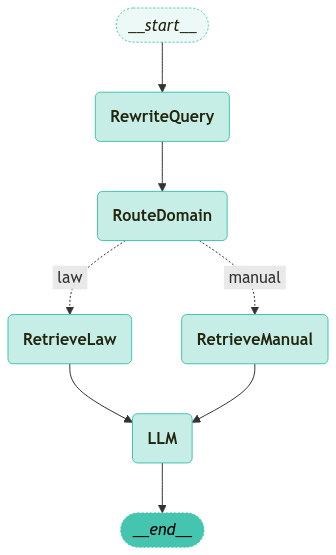

In [30]:
import os
from functools import partial
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

# Node 함수 import
from langgraph_utill import (
    query_rewrite_llm,
    route_domain_llm,
    # retrieve_document_law,
    retrieve_document_manual,
    call_model
)
from langgraph_utill import State
from langchain_core.messages import HumanMessage


rewriter_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
rewrite_prompt = """
# Instruction:
    - 아래 질문을 더 간결하고 명확하게 재작성해줘.
    - 출력은 한 문장으로만.

# Example:
    Query: 관세법제89조는 어떤 법이야?
    Answer: 관세법 제89조의 내용은 무엇인가요?

Query: {query}
Answer: 
"""


routing_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
routing_prompt = """
# Instruction:
    - 아래 질문이 'law' 아니면 'manual'인지 결정.
    - 조건:
        - 법령, 조항, 규정 -> 'law'
        - 제품 사용 설명, 기능 -> 'manual'
        - 출력은 소문자로 'law' 또는 'manual'만

# Example:
    Query: 관세법제89조는 어떤 법이야?
    Answer: 'law'

Query: {query}
Answer: 
"""


law_retriever = law_retriever
manual_retriever = ...


final_prompt = """
Context:
{context}

User question: {question}

Answer:
"""
final_llm = ChatOllama(model="cqmodel:latest", num_thread=12, top_k=5) 


memory = MemorySaver()
graph_builder = StateGraph(State)

# 노드 등록 (Rewrite -> Domain -> Retrieve -> LLM -> END)

graph_builder.add_node(
    "RewriteQuery",
    partial(query_rewrite_llm, rewriter_llm=rewriter_llm, rewrite_prompt=rewrite_prompt)
)

graph_builder.add_node(
    "RouteDomain",
    partial(route_domain_llm, routing_llm=routing_llm, routing_prompt=routing_prompt)
)

graph_builder.add_node(
    "RetrieveLaw",
    partial(retrieve_document_law, law_retriever=law_retriever)
)
graph_builder.add_node(
    "RetrieveManual",
    partial(retrieve_document_manual, manual_retriever=manual_retriever)
)

graph_builder.add_node(
    "LLM",
    partial(call_model, prompt=final_prompt, llm=final_llm)
)

graph_builder.add_edge("RewriteQuery", "RouteDomain")

graph_builder.add_conditional_edges(
    "RouteDomain",
    domain_condition,
    {
        "law": "RetrieveLaw",
        "manual": "RetrieveManual"
    }
)

graph_builder.add_edge("RetrieveLaw", "LLM")
graph_builder.add_edge("RetrieveManual", "LLM")
graph_builder.add_edge("LLM", END)

graph_builder.set_entry_point("RewriteQuery")
graph = graph_builder.compile(checkpointer=memory)

visualize_graph(graph)

In [31]:
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "6344"},  # 스레드 ID 설정
)

In [32]:
inputs = State(question="관세법제89조는 어떤 법이야?")

In [ ]:
prev_node = ""
node_names = ["RewriteQuery", "RouteDomain", "RetrieveLaw", "RetrieveManual", "LLM"]
for chunk_msg, metadata in graph.stream(inputs, config, stream_mode="messages"):
    curr_node = metadata["langgraph_node"]
    # print(curr_node)
    # node_names가 비어있거나 현재 노드가 node_names에 있는 경우에만 처리
    
    if not node_names or curr_node in node_names:
        # 콜백 함수가 있는 경우 실행
        # if callback:
        #     callback({"node": curr_node, "content": chunk_msg.content})
        # 콜백이 없는 경우 기본 출력
        
        # if curr_node == "RewriteQuery":
        #     print(chunk_msg.content, end="")

            # 노드가 변경된 경우에만 구분선 출력
        if curr_node != prev_node:
            print("\n" + "=" * 50)
            print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
            print("- " * 25)
        print(chunk_msg.content, end="", flush=True)

        prev_node = curr_node


🔄 Node: RewriteQuery 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
관세법 제89조의 내용은 무엇인가요?
🔄 Node: RouteDomain 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
law
🔄 Node: RetrieveLaw 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[관세법] 제229조(원산지 확인 기준)   1항 이 법, 조약, 협정 등에 따른 관세의 부과ㆍ징수, 수출입물품의 통관, 제233조제3항의 확인요청에 따른 조사 등을 위하여 원산지를 확인할 때에는 다음 각 호의 어느 하나에 해당하는 나라를 원산지로 한다. <개정 2014. 1. 1.> 
1. 해당 물품의 전부를 생산ㆍ가공ㆍ제조한 나라 
2. 해당 물품이 2개국 이상에 걸쳐 생산ㆍ가공 또는 제조된 경우에는 그 물품의 본질적 특성을 부여하기에 충분한 정도의 실질적인 생산ㆍ가공ㆍ제조 과정이 최종적으로 수행된 나라 
2항 제1항 각 호를 적용할 물품의 범위, 구체적 확인 기준 등에 관하여 필요한 사항은 기획재정부령으로 정한다. 
3항 제1항과 제2항에도 불구하고 조약ㆍ협정 등의 시행을 위하여 원산지 확인 기준 등을 따로 정할 필요가 있을 때에는 기획재정부령으로 원산지 확인 기준 등을 따로 정한다. 
 [전문개정 2010. 12. 30.]
🔄 Node: LLM 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
제89조는 원산지 확인 기준에 따라 물품의 원산지를 확인하는 데 필요한 절차와 기준을 정합니다. 원산지 확인 기준에는 2개국 이상의 생산, 가공 또는 제조가 이루어졌을 경우 본질적 특성을 부여하기 위해 충분한 실질적인 생산, 가공 또는 제조 과정이 수행된 나라를 원산지로 한다는 점이 중요합니다. 또한, 기획재정부령에 따라 구체적인 확인 기준과 범위 등에 대한 사항은 정해집니다.

### 